In [1]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings

warnings.filterwarnings("ignore")


In [2]:
s, x,z,y= generate_data_survivl(n=10000,T=5)

In [3]:
np.mean(y[x[:,2]==1,2])-np.mean(y[x[:,2]==0,2])

2.318335394264458

In [4]:
np.mean(y[x[:,0]==1,2])-np.mean(y[x[:,0]==0,2])

0.26138522238099793

In [5]:
s = torch.tensor(s, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
z = torch.tensor(z, dtype=torch.float32)

In [6]:
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=5, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = True)

In [8]:
model.train_xz(x=x, z=z, y=y, s=s, num_iters=6000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 1.6488, loss1 1.7195, loss2 0.1413
Epoch 1000: loss 1.0313, loss1 2.0517, loss2 2.0409
Epoch 2000: loss 1.0177, loss1 2.0388, loss2 2.0422
Epoch 3000: loss 1.0202, loss1 2.0446, loss2 2.0487
Epoch 4000: loss 1.0197, loss1 2.0458, loss2 2.0522
Epoch 5000: loss 1.0128, loss1 2.0406, loss2 2.0555
Epoch 6000: loss 1.0178, loss1 2.0444, loss2 2.0531


In [7]:
model.train_y(x=x,z=z,y=y,num_iters=5000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 6.2106,	loss_y 4.1500, 4.2258, 0.1517,	loss_eta 2.0606, 2.1281, 0.1349
Epoch 1000: loss 3.3640,	loss_y 1.8453, 3.6798, 3.6691,	loss_eta 1.5187, 3.0040, 2.9705
Epoch 2000: loss 3.3569,	loss_y 1.8484, 3.6877, 3.6786,	loss_eta 1.5084, 2.9934, 2.9700
Epoch 3000: loss 3.3536,	loss_y 1.8472, 3.6758, 3.6573,	loss_eta 1.5064, 2.9890, 2.9651
Epoch 4000: loss 3.3457,	loss_y 1.8300, 3.6490, 3.6380,	loss_eta 1.5157, 2.9967, 2.9620
Epoch 5000: loss 3.3217,	loss_y 1.8184, 3.6171, 3.5974,	loss_eta 1.5033, 2.9844, 2.9622


In [16]:
# model.predict_causal(x=torch.tensor([[1,1,1,1,1]]), sample_size=1)

In [22]:
x=torch.tensor([[1,1,1,1,1]])
yt = model.model_y[4].sample(x[:,:5], sample_size=10)
yt.view(-1).numpy()

array([ 6.8297563 ,  2.4762182 ,  2.2519543 ,  5.404599  , -0.50246567,
        2.3408365 , -0.8101894 ,  2.7694387 ,  3.363973  ,  1.2320951 ],
      dtype=float32)

In [25]:
y_all = []
for t in range(5):
    yt = model.model_y[t].sample(x[:,:(t+1)], sample_size=1000)
    y_all.append(yt.view(-1).numpy())

(array([ 4., 14., 20., 44., 31., 36., 33., 13.,  4.,  1.]),
 array([-3.54060245, -2.50748301, -1.47436333, -0.44124377,  0.59187579,
         1.62499535,  2.65811491,  3.69123459,  4.72435379,  5.75747347,
         6.79059315]),
 <BarContainer object of 10 artists>)

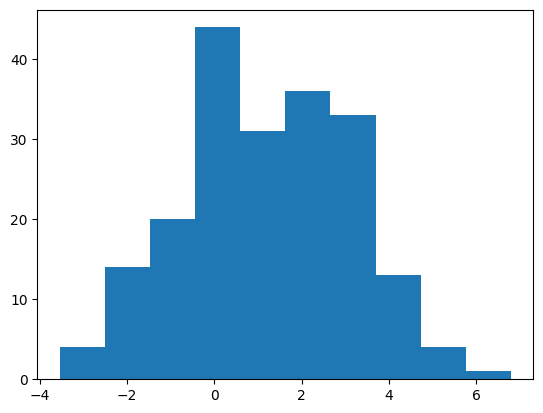

In [10]:
plt.hist(result.view(-1).numpy())

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gaussian_kde
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


# Convert torch tensors to numpy arrays
y_lists_np = y_all

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(5)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()


ValueError: `dataset` input should have multiple elements.

<Figure size 1200x800 with 0 Axes>